In [22]:
import netCDF4
import math
import xarray as xr
import dask
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import transforms
from matplotlib.animation import PillowWriter

In [23]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/Small_Sample/Useful_Files/Amazon_Rainforest.nc'
amazon = xr.open_dataset(path_to_file)
#test_ds.variables

path_to_file = '/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/Small_Sample/Useful_Files/Siberia.nc'
siberia = xr.open_dataset(path_to_file)
#test_ds.variables

path_to_file = '/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/Small_Sample/New_SPCAM5/TimestepOutput_Neuralnet_SPCAM_216/run/Cpac_gridcell_rcat.nc'
test_ds = xr.open_dataset(path_to_file)
#test_ds.variables

isolate the useful variables

In [24]:
amazon_T = np.squeeze(amazon.CRM_T.values)
amazon_Vapor = np.squeeze(amazon.CRM_QV.values)
amazon_W = np.squeeze(amazon.CRM_W.values)

siberia_T = np.squeeze(siberia.CRM_T.values)
siberia_Vapor = np.squeeze(siberia.CRM_QV.values)
siberia_W = np.squeeze(siberia.CRM_W.values)

test_T = np.squeeze(test_ds.CRM_T.values)
test_Vapor = np.squeeze(test_ds.CRM_QV.values)
test_W = np.squeeze(test_ds.CRM_W.values)

In [25]:
# General
cp = 1.004e3
g = 9.81
Lv = 2.5104e6
Lf = 0.3336e6
Ls = 2.8440e6
R = 287
Rv = 461
T0 = 273.16
T0p = 283.16
T00 = 253.16
T00p = 268.16

In [26]:
#import scipy.integrate as sin
# Ideal gas law -> rho=p(R_d*T_v)
#eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
#R_D = 287 # Specific gas constant of dry air in J/K/kg
#r = NNQBP/(NNQBP**0-NNQBP)
#Tv = NNTBP*(r**0+r/eps)/(r**0+r)
#RHO = 1e2*cam_ds.lev.values/(R_D*Tv)
#Z = -sin.cumtrapz(x=1e2*cam_ds.lev.values,y=1/(g*RHO))
###Z = -sin.cumtrapz(x=P = (hyam*P0+hybm*PS),y=1/(G*RHO)) - better method - implement later
#Z = np.concatenate((np.zeros(1,),Z))
#Z = Z-Z[-1]+Z_INTERP[-1] #at lowest level interface make sure Z is zero

In [27]:
def Z_improved(crm_QBP):
    eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
    R_D = 287 # Specific gas constant of dry air in J/K/kg

In [28]:
#FMSE = cp*amazon.CRM_T+Lv*amazon.CRM_QC+g*amazon.lev

In [29]:
print(siberia_W.shape)

(96, 30, 128)


Develope Animations to track vertical velocities over the course of the test day

In [30]:
def utc_timing(times):
    utc_list = []
    end_times = [':00',':15',':30',':45']
    counter = 0
    thing = 0
    for i in range(times):
        if thing == 95:
            thing = 0
        
        beg_time = int(thing/4)
        if beg_time == 0:
            beg_time = 24
        ending = end_times[counter]
        counter = counter + 1
        if counter  == 4:
            counter = 0
        
        utc_time = str(beg_time)+ending
        utc_list.append(utc_time)
        thing = thing + 1
        
        
    
    #print(utc_list)
    return utc_list

In [31]:
varname = "Vertical Velocity"
location = 'Amazon'
units = "m/s"
savepath = 'W'

def anime_col(values, var, unit, save, local):
    plt.rcParams['animation.ffmpeg_path'] = '/export/home/gmooers/miniconda3/bin/ffmpeg'
    container = []

    
    fig, ax = plt.subplots(1, 1)
    times = len(values)
    utc_list = utc_timing(times)
    for i in range(times):
            
        #base = plt.gca().transData
        #rot = transforms.Affine2D().rotate_deg(270)
        
        im = ax.pcolor(np.squeeze(values[i,:, :]), vmin = -0.22, vmax = 0.22, cmap = 'coolwarm', animated= True) #transform = rot + base)
        if i ==0:
            fig.colorbar(im, label=var+' '+unit)
        plt.ylabel("Pressure")
        plt.xlabel('CRMs')
        title_feat = ax.text(0.5,1.05,var+' at '+local+" at "+utc_list[i], 
                    size=10,
                    ha="center", transform=ax.transAxes, )
        
        my_yticks = np.arange(50, 1000, 150)
        my_yticks[::-1].sort()
        ax.set_yticklabels(my_yticks)
        
        yticks = ax.yaxis.get_major_ticks()
        yticks[0].label1.set_visible(False)
        yticks[-1].label1.set_visible(False)
    
        container.append([im, title_feat])
      
    ani = animation.ArtistAnimation(fig, container, interval = 150, blit = True, repeat = True)
    ani.save('/fast/gmooers/Figures/Animate/Single_Day_'+save+'_'+local+'_Animations.mp4')
    #plt.show()
    
#anime_col(amazon_W, varname, units, savepath, location)

In [32]:
location = 'Siberia'
#anime_col(siberia_W, varname, units, savepath, location)

In [33]:
location = '180E_0N'
#anime_col(test_W, varname, units, savepath, location)

Repeat animations for Moist Static Energy

$H = c_p*T+g*z+L_v*q$


cp = specific heat of air ($\frac{Joules}{kg*K}$)

T = temperature (K)

g = gravity constant ($\frac{m}{s^2}$)

z = altitude (m)

$L_v$ is latent heat of Vaporization $\frac{Joules}{kg}$

q = Specific humidity $\frac{kg}{kg}$

However, q, specific humidity, or the mixing ratio are not provided by CRM variales grabbed in this simulation - maybe fix that in future.

For now, will appoximate the mixing ratio, w, from:

$w = 0.622\frac{e_s}{p-e_s}$

and the saturation vapor pressure, $e_s$ can be derived from given temperature information from the Clausius Clayperion equation (Hartmann textbook):

$e_s = 6.11*e^{\frac{L_v}{R_v}*(\frac{1}{273}-\frac{1}{T})}$

In [34]:
QV = test_ds.CRM_QV.values

In [35]:
def pressure_shaper(variable, pressures):
    new_pressures = variable
    for i in range(len(new_pressures)):
        for j in range(len(new_pressures[0][0])):
            new_pressures[i,:,j] = pressures
    
    return new_pressures

def mixing_ratio(temps, pressures):
    e_s = temps
    for i in range(len(temps)):
        for j in range(len(temps[i])):
            for k in range(len(temps[i][j])):
                e_s[i,j,k] = 6.11*math.exp(2501000.0/461.0*(1.0/273.0-1.0/temps[i,j,k]))
    
    w = e_s
    for i in range(len(e_s)):
        for j in range(len(e_s[i])):
            for k in range(len(e_s[i][j])):
                w[i,j,k] = 0.622*e_s[i,j,k]/(pressures[j]-e_s[i,j,k])
    
    return w

In [36]:
def MSE_gen(temps, pressures):
    w = mixing_ratio(temps, pressures)
    new_pressures = pressure_shaper(temps, pressures)
    MSE = 1004.0*temps+2501000.0*w+new_pressures*9.81
    return MSE

In [38]:
#test_MSE = MSE_gen(test_T, levs)
#amazon_MSE = MSE_gen(amazon_T, levs)
#siberia_MSE = MSE_gen(siberia_T, levs)

In [39]:
def anime_col(values, var, unit, save, local):
    plt.rcParams['animation.ffmpeg_path'] = '/export/home/gmooers/miniconda3/bin/ffmpeg'
    container = []

    
    fig, ax = plt.subplots(1, 1)
    times = len(values)
    utc_list = utc_timing(times)
    for i in range(times):
            
        #base = plt.gca().transData
        #rot = transforms.Affine2D().rotate_deg(270)
        
        im = ax.pcolor(np.squeeze(values[i,:, :]), cmap = 'coolwarm', animated= True) #transform = rot + base)
        if i ==0:
            fig.colorbar(im, label=var+' '+unit)
        plt.ylabel("Pressure")
        plt.xlabel('CRMs')
        title_feat = ax.text(0.5,1.05,var+' at '+local+" at "+utc_list[i], 
                    size=10,
                    ha="center", transform=ax.transAxes, )
        
        my_yticks = np.arange(50, 1000, 150)
        my_yticks[::-1].sort()
        ax.set_yticklabels(my_yticks)
        
        yticks = ax.yaxis.get_major_ticks()
        yticks[0].label1.set_visible(False)
        yticks[-1].label1.set_visible(False)
    
        container.append([im, title_feat])
      
    ani = animation.ArtistAnimation(fig, container, interval = 150, blit = True, repeat = True)
    ani.save('/fast/gmooers/Figures/Animate/Single_Day_'+save+'_'+local+'_Animations.mp4')
    #plt.show()
    
#anime_col(siberia_W, varname, units, savepath, location)

In [40]:
varname = "Moist Static Energy"
location = 'Amazon'
units = "J/kg"
savepath = 'MSE'
#anime_col(amazon_MSE, varname, units, savepath, location)

In [41]:
location = 'Siberia'
#anime_col(siberia_MSE, varname, units, savepath, location)

In [42]:
location = '0N_180E'
#anime_col(test_MSE, varname, units, savepath, location)

Results above seem very wrong - so will simplify to enthalpy?

In [43]:
def Enthalpy_gen(temps, water_vapor):
    Enthalpy = 1004.0*temps+2501000.0*water_vapor
    return Enthalpy

test_Enthalpy = Enthalpy_gen(test_T, test_Vapor)
amazon_Enthalpy = Enthalpy_gen(amazon_T, amazon_Vapor)
siberia_Enthalpy = Enthalpy_gen(siberia_T, siberia_Vapor)

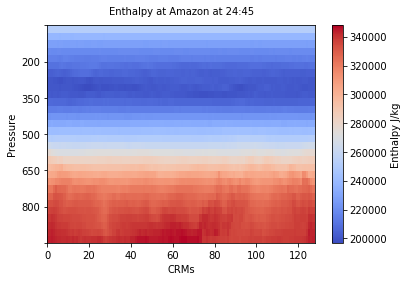

In [44]:
varname = "Enthalpy"
location = 'Amazon'
units = "J/kg"
savepath = 'Enthalpy'
anime_col(amazon_Enthalpy, varname, units, savepath, location)

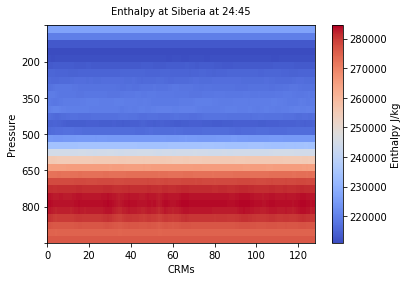

In [45]:
location = 'Siberia'
anime_col(siberia_Enthalpy, varname, units, savepath, location)

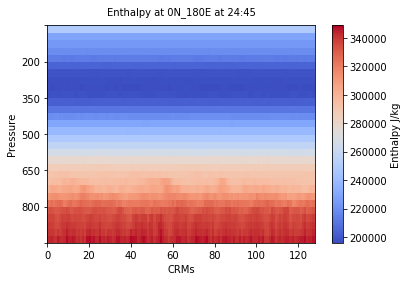

In [46]:
location = '0N_180E'
anime_col(test_Enthalpy, varname, units, savepath, location)